In [1]:
import datetime
import logging
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from tqdm import tqdm
from utils.forecast import get_dwd_forecast

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.forecast import get_dwd_forecast
from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl

In [2]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"
DOUBLE_COL_FIG_SIZE = (15, 5)

In [3]:
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
)

First look at one specific station


In [4]:
STATION_ID = 257

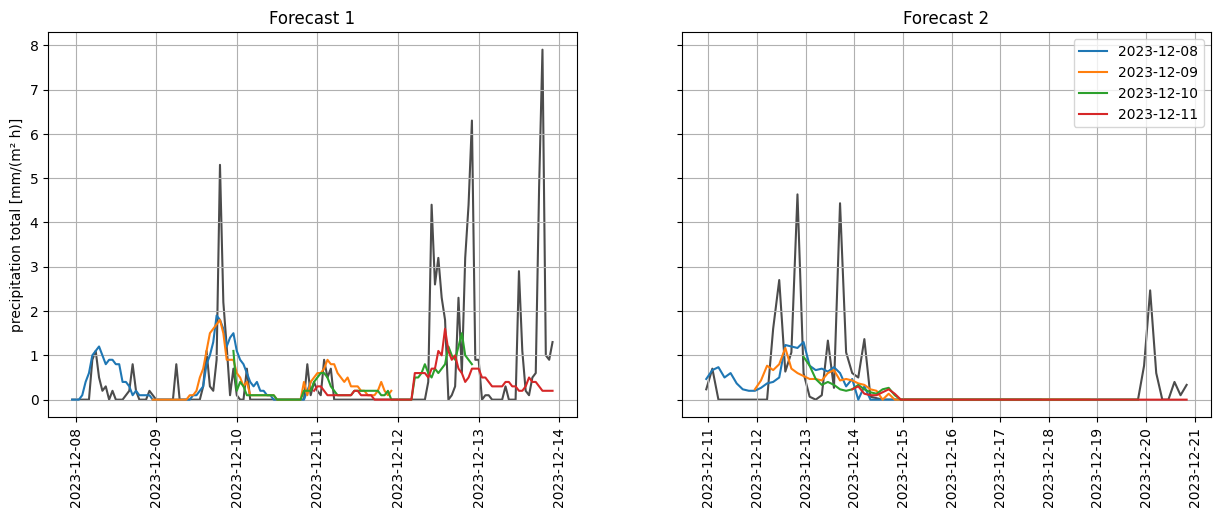

In [5]:
import pandas


forecast1 = dataset_model_1.get_merge(station_id=STATION_ID).copy()
forecast2 = dataset_model_2.get_merge(station_id=STATION_ID).copy()


forecast1["call_time"] = forecast1["call_time"].dt.normalize()
forecast2["call_time"] = forecast2["call_time"].dt.normalize()


# num call times
num_call_times = 4

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)
call_times = sorted(forecast1["call_time"].unique())
for call_time in call_times[:num_call_times]:
    sub_df_forecast = forecast1[forecast1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    # axs[0].plot(t, sub_df_forecast["precipitation_real"], color="k", alpha=0.2)
    axs[0].plot(
        t,
        values,
        label=call_time.date(),
    )

    sub_df_forecast = forecast2[forecast2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"] / 3
    # axs[1].plot(t, sub_df_forecast["precipitation_real"] / 3, color="k", alpha=0.2)
    axs[1].plot(t, values, label=call_time.date())

# add historical context
# model 1
sub_df = forecast1[
    forecast1["call_time"].isin(call_times[:num_call_times])
    & (forecast1["station_id"] == STATION_ID)
]
min_time = min(sub_df["time"])
max_time = max(sub_df["time"])
real = forecast1[
    (forecast1["time"] <= max_time)
    & (forecast1["time"].values >= min_time)
    & (forecast1["station_id"] == STATION_ID)
].sort_values(by="time")
axs[0].plot(real["time"], real["precipitation_real"], zorder=0, c="k", alpha=0.7)
# model 2
sub_df = forecast2[
    forecast2["call_time"].isin(call_times[:num_call_times])
    & (forecast2["station_id"] == STATION_ID)
]
min_time = min(sub_df["time"])
max_time = max(sub_df["time"])
real = forecast2[
    (forecast2["time"] <= max_time)
    & (forecast2["time"].values >= min_time)
    & (forecast2["station_id"] == STATION_ID)
].sort_values(by="time")
axs[1].plot(real["time"], real["precipitation_real"] / 3, zorder=0, c="k", alpha=0.7)


axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Forecast 1")
axs[0].set_ylabel("precipitation total [mm/(m² h)]")
axs[0].grid()
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Forecast 2")
axs[1].legend()
axs[1].grid()


fig.savefig(FIG_SAVE_BASE_PATH + "precipitation_forecast.pdf")

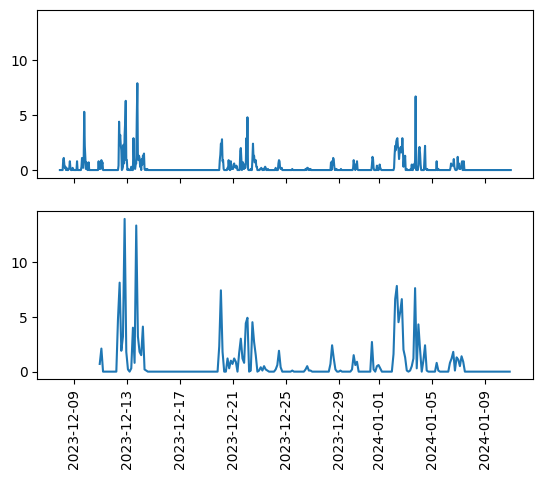

In [6]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
real_data = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[0].plot(real_data["time"], real_data["precipitation_real"])
real_data = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[1].plot(real_data["time"], real_data["precipitation_real"])

axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)

Text(0.5, 0.98, 'Difference: Precipitation Forecast and Historical Precipitation for station: 257')

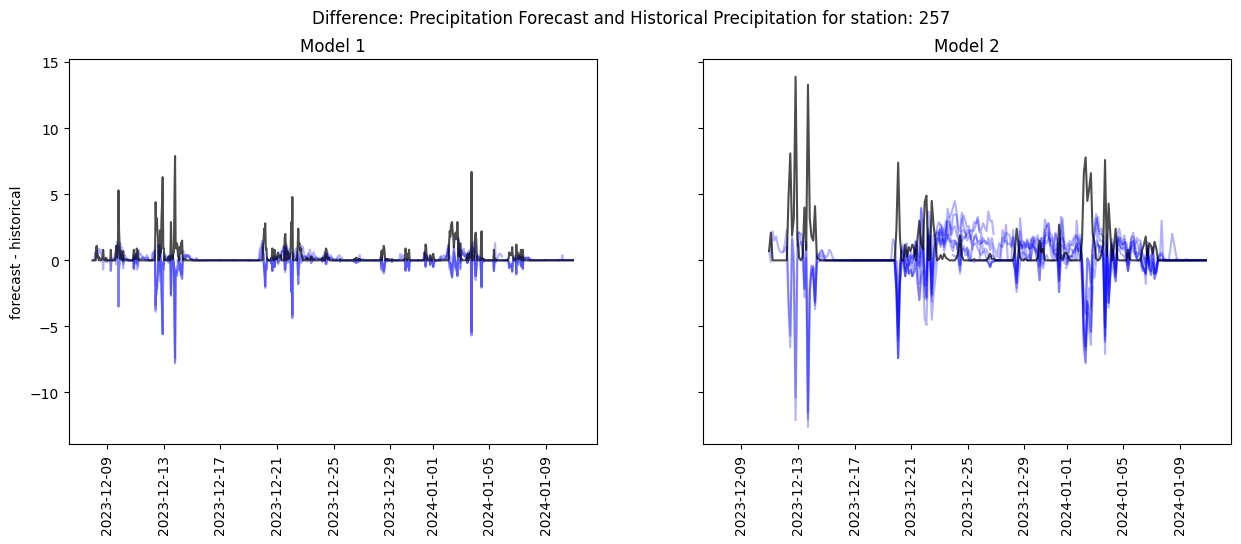

In [7]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE, sharey=True
)
merge1 = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
merge2 = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")

# fig, ax1 = plt.subplots()

api_call_times = sorted(merge1["call_time"].unique())
num_api_calls = len(api_call_times)
for idx, call_time in enumerate(api_call_times):
    sub_df_forecast = merge1[merge1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax1.plot(t, error, c="b", alpha=0.3)

    sub_df_forecast = merge2[merge2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax2.plot(t, error, c="b", alpha=0.3)

# plot real amount of rain
ax1.plot(
    merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain"
)
ax2.plot(
    merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain"
)

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
fig.suptitle(
    "Difference: Precipitation Forecast and Historical Precipitation for station: "
    + str(STATION_ID)
)

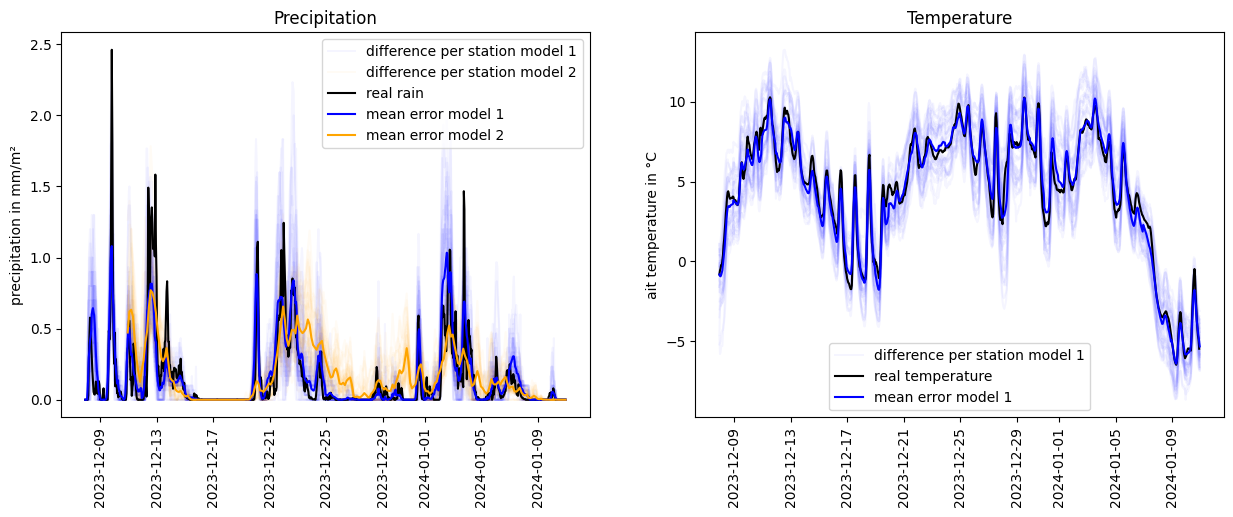

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE)
merge1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_forecast"],
        c="blue",
        alpha=0.04,
        label="difference per station model 1" if not idx else "",
    )

    ax2.plot(
        sub_df.index,
        sub_df["air_temperature_forecast"],
        c="blue",
        alpha=0.04,
        label="difference per station model 1" if not idx else "",
    )

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_forecast"] / 3,
        c="orange",
        alpha=0.04,
        label="difference per station model 2" if not idx else "",
    )


time_group = merge1.groupby(["time"]).mean()
ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(
    time_group.index,
    time_group["precipitation_forecast"],
    c="b",
    label="mean error model 1",
)


time_group = merge2.groupby(["time"]).mean()
ax1.plot(
    time_group.index,
    time_group["precipitation_forecast"] / 3,
    c="orange",
    label="mean error model 2",
)

time_group = merge1.groupby(["time"]).mean()
ax2.plot(
    time_group.index,
    time_group["air_temperature_real"],
    c="k",
    label="real temperature",
)
ax2.plot(
    time_group.index,
    time_group["air_temperature_forecast"],
    c="b",
    label="mean error model 1",
)


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
#
#
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


#
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#
#
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
#
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
#
# # compute correlation

what is the relative error $(forecast - historical) / historical$


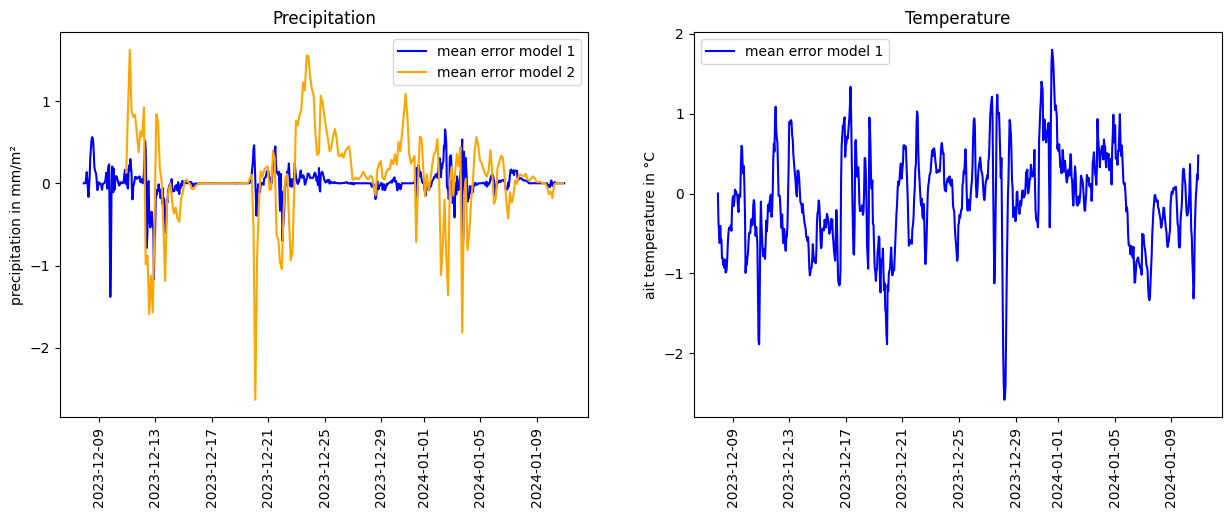

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE)
merge1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

    # ax2.plot(sub_df.index, sub_df["air_temperature_error"], c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="orange", alpha=0.04, label="difference per station model 2" if not idx else "")


time_group = merge1.groupby(["time"]).mean()
# ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(
    time_group.index,
    time_group["precipitation_error"],
    c="b",
    label="mean error model 1",
)


time_group = merge2.groupby(["time"]).mean()
ax1.plot(
    time_group.index,
    time_group["precipitation_error"],
    c="orange",
    label="mean error model 2",
)

time_group = merge1.groupby(["time"]).mean()
# ax2.plot(time_group.index, time_group["air_temperature_real"], c="k", label="real temperature")
ax2.plot(
    time_group.index,
    time_group["air_temperature_error"],
    c="b",
    label="mean error model 1",
)


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
#
#
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


#
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#
#
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
#
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
#
# # compute correlation

What is the general trend of the error in model 1 and model 2


In [10]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[
            (merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)
        ]

        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])

    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)

In [11]:
merge2 = dataset_model_2.get_merge()

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[
            (merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)
        ]

        if (
            len(sub_df_forecast) < 56
        ):  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])

    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)
error_mat_model_2 /= 3

coef:  [0.14977453 0.00040149]
(25, 36, 56)
coef:  [1.86403648e-01 2.10361763e-05]


Text(0.5, 1.0, 'Model 2')

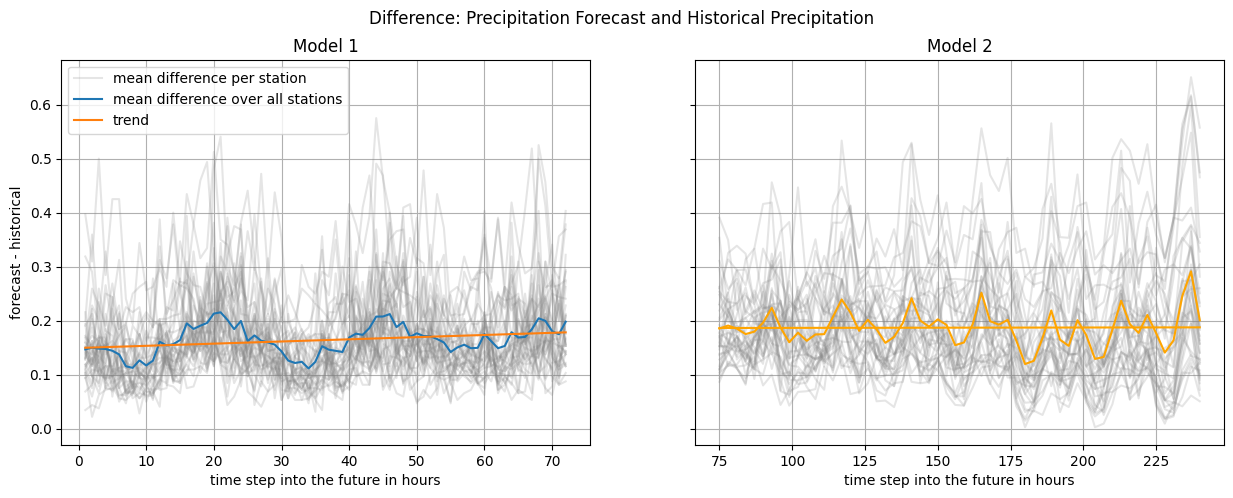

In [12]:
error_mat_model_1 = np.abs(error_mat_model_1)
error_mat_model_2 = np.abs(error_mat_model_2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# MODEL 1

station_errors = error_mat_model_1.mean(axis=0)
x_axis = np.arange(1, station_errors.shape[-1] + 1)

for idx, station_error in enumerate(station_errors):
    ax1.plot(
        x_axis,
        station_error,
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
    )
forecast_error = station_errors.mean(axis=0)
ax1.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef
print("coef: ", regression_coef)

ax1.plot(x_axis, regression, label="trend")

ax1.grid()
ax1.legend()
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")


# MODEL 2
print(error_mat_model_2.shape)
station_errors = error_mat_model_2.mean(axis=0)
x_axis = (np.arange(1, station_errors.shape[-1] + 1) * 3) + 72

for idx, station_error in enumerate(station_errors):
    ax2.plot(
        x_axis,
        station_error,
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
    )
forecast_error = station_errors.mean(axis=0)
ax2.plot(x_axis, forecast_error, label="mean difference over all stations", c="orange")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax2.plot(x_axis, regression, label="trend", c="orange")

ax2.grid()
ax2.set_xlabel("time step into the future in hours")
print("coef: ", regression_coef)

ax2.set_title("Model 2")

# TODO: ask if we would use bar plots -> h

coef model 1
[-0.01037899  0.00042979]
coef model 2
[ 0.06179625 -0.00128238]


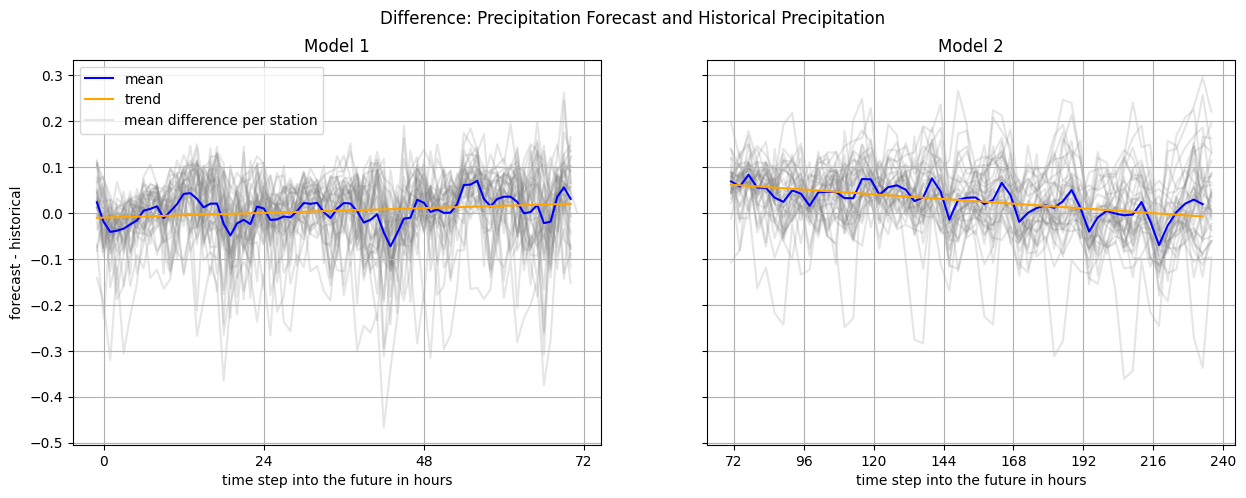

In [13]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


# plot means
mean_time_delta = merge1.groupby("time_delta").mean().iloc[:-1]
t = mean_time_delta.index.values / (3600 * 1e9)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c="b", label="mean")
# trend regression
x = np.arange(len(mean_time_delta))[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = (
    np.linalg.inv(x_aug.T @ x_aug)
    @ x_aug.T
    @ mean_time_delta["precipitation_error"].values
)
regression = x_aug @ regression_coef
ax1.plot(t, regression, color="orange", label="trend")
print("coef model 1")
print(regression_coef)

mean_time_delta = merge2.groupby("time_delta").mean().iloc[:-1]
t = mean_time_delta.index.values / (3600 * 1e9)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c="b", label="mean")
# trend regression
x = np.arange(len(mean_time_delta))[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = (
    np.linalg.inv(x_aug.T @ x_aug)
    @ x_aug.T
    @ mean_time_delta["precipitation_error"].values
    / 3
)
regression = x_aug @ regression_coef
ax2.plot(t, regression, color="orange", label="trend")
print("coef model 2")
print(regression_coef)


# plot grey lines per station
mean_time_delta = merge1.groupby(["time_delta", "station_id"]).mean().iloc[:-1]
for idx, station_id in enumerate(merge1["station_id"].unique()):
    sub_df = mean_time_delta.xs(station_id, level="station_id")
    t = sub_df.index.values / (3600 * 1e9)  # to hours
    ax1.plot(
        t,
        sub_df["precipitation_error"],
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
        zorder=0,
    )

# plot grey lines per station
mean_time_delta = merge2.groupby(["time_delta", "station_id"]).mean().iloc[:-1]
for idx, station_id in enumerate(merge2["station_id"].unique()):
    sub_df = mean_time_delta.xs(station_id, level="station_id")
    t = sub_df.index.values / (3600 * 1e9)  # to hours
    ax2.plot(
        t,
        sub_df["precipitation_error"] / 3,
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
        zorder=0,
    )


ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")
ax1.set_xticks(np.linspace(0, 72, 4, dtype=int), np.linspace(0, 72, 4, dtype=int))
ax1.grid()
ax1.legend()

ax2.set_title("Model 2")
ax2.set_xlabel("time step into the future in hours")
ax2.set_xticks(
    np.linspace(0, 56, 8, dtype=int) * 3 + 72, np.linspace(0, 56, 8, dtype=int) * 3 + 72
)
ax2.grid()


# TODO: one plot?????
# TODO: what is more important: graphic with grey line or tube of standard diviation?

FFT


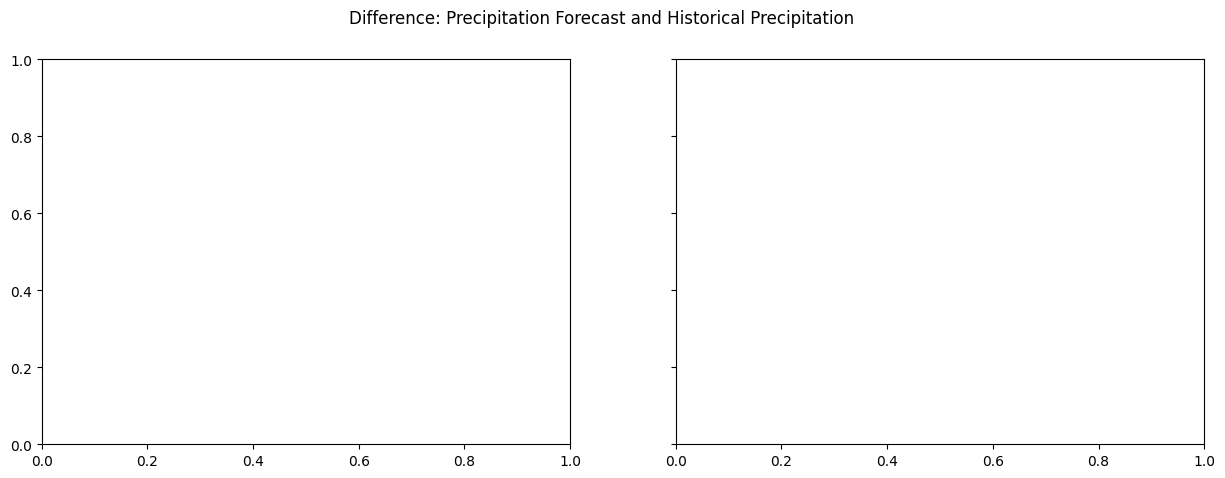

In [14]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()


# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)

get confidence intervalls of the mean curve (blue) with bootstrap


In [15]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000

# MODEL 1

flatten_errors_1 = np.concatenate(error_mat_model_1, axis=0)
N_1 = len(
    flatten_errors_1
)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_1 = np.empty((flatten_errors_1.shape[1], N_BOOT))

for idx, time_step_error in enumerate(
    tqdm(flatten_errors_1.T, desc="Bootstrap Model 1")
):
    simulated_errors = np.random.choice(
        time_step_error, size=(N_BOOT, N_1), replace=True
    )
    mean_1 = simulated_errors.mean(axis=1)
    # print(boot_strap_means_1.shape, mean.shape)
    boot_strap_means_1[idx] = simulated_errors.mean(axis=1)
# MODEL 2

flatten_errors_2 = np.concatenate(error_mat_model_2, axis=0)
N_2 = len(
    flatten_errors_2
)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_2 = np.empty((flatten_errors_2.shape[1], N_BOOT))

for idx, time_step_error in enumerate(
    tqdm(flatten_errors_2.T, desc="Bootstrap Model 2")
):
    simulated_errors = np.random.choice(
        time_step_error, size=(N_BOOT, N_1), replace=True
    )
    mean_1 = simulated_errors.mean(axis=1)
    boot_strap_means_2[idx] = simulated_errors.mean(axis=1)

Bootstrap Model 2: 100%|██████████| 56/56 [00:05<00:00, 10.33it/s]


In [16]:
boot_strap_means_2.shape

(56, 10000)

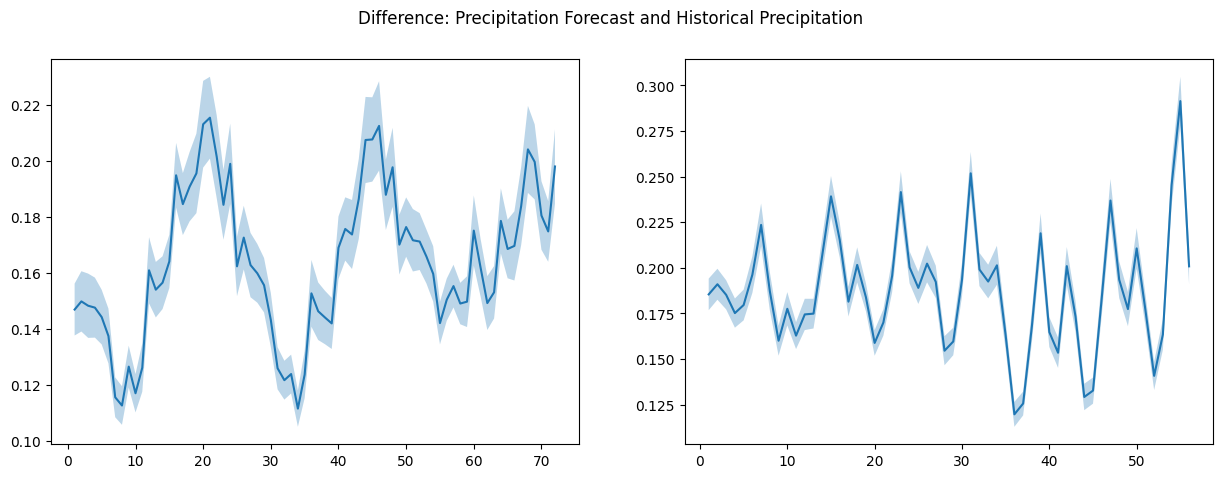

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

x_axis = np.arange(1, 73)
mean_1 = boot_strap_means_1.mean(axis=1)
std_1 = boot_strap_means_1.std(axis=1)

ax1.plot(x_axis, mean_1)
ax1.fill_between(x_axis, mean_1 - std_1, mean_1 + std_1, alpha=0.3)


x_axis = np.arange(1, 57)
mean_2 = boot_strap_means_2.mean(axis=1)
std_2 = boot_strap_means_2.std(axis=1)

ax2.plot(x_axis, mean_2)
ax2.fill_between(x_axis, mean_2 - std_2, mean_2 + std_2, alpha=0.3)

# TODO: ellipse plots????

look at the covariance between the estimated mean and the estimated standard variance.


Correlation matrix between mean and standard variance for model 1
[[1.98811681 0.13235366]
 [0.13235366 0.00889496]]
Correlation matrix between mean and standard variance for model 2
[[2.01589114 0.0978558 ]
 [0.0978558  0.00477303]]


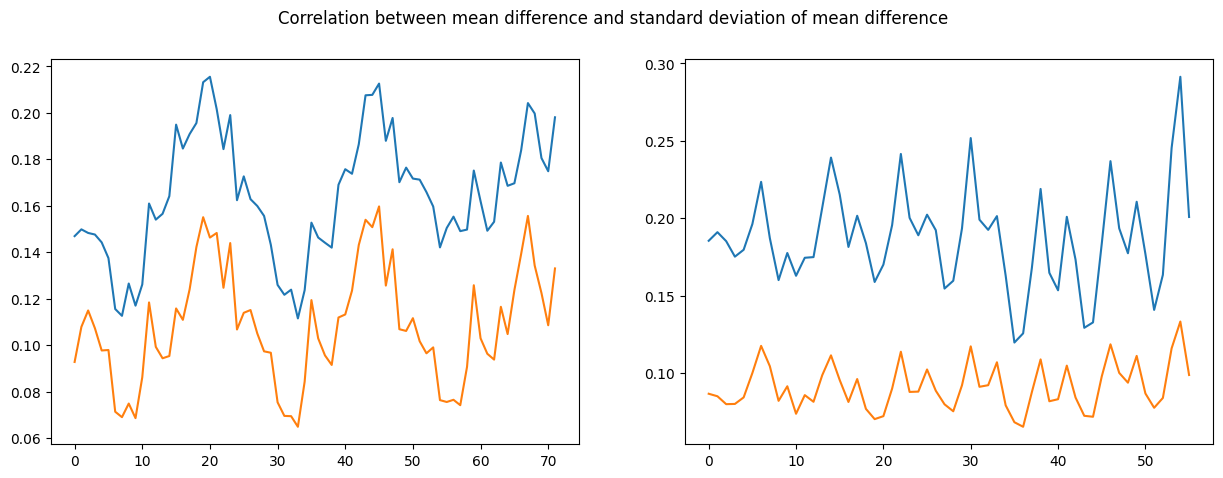

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle(
    "Correlation between mean difference and standard deviation of mean difference"
)


ax1.plot(mean_1)
ax1.plot(std_1 * 10)

estimator_properties = np.stack([mean_1, std_1]).T
print("Correlation matrix between mean and standard variance for model 1")
print(estimator_properties.T @ estimator_properties)

ax2.plot(mean_2)
ax2.plot(std_2 * 10)

estimator_properties = np.stack([mean_2, std_2]).T
print("Correlation matrix between mean and standard variance for model 2")
print(estimator_properties.T @ estimator_properties)

Do a FFT on errors:


Do fft: 100%|██████████| 1/1 [00:00<00:00, 7384.34it/s]


Text(0.5, 0, 'Frequency in 1 / day ')

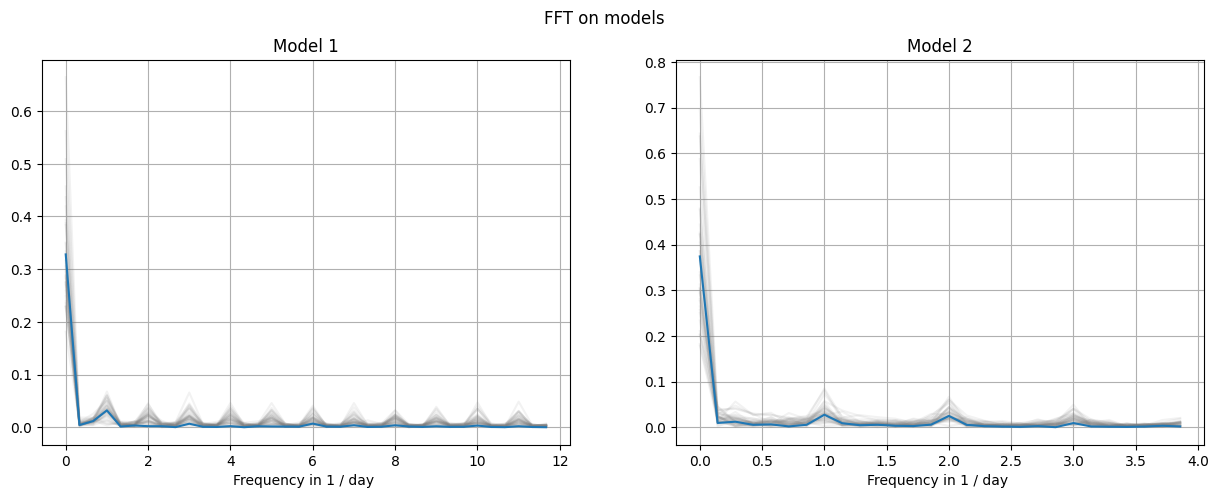

In [19]:
from typing import Tuple
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt


def do_fft(time_series: np.ndarray, period: float = 1) -> Tuple[np.ndarray, np.ndarray]:
    """perform fft on given time series

    Args:
        time_series (np.ndarray): shape (num_series, length of series)
        period (float, optional): _description_. Defaults to 1.

    Returns:
        Tuple[np.ndarray, np.ndarray]: _description_
    """
    # Number of sample points
    N = time_series.shape[-1]
    # sample spacing

    result = np.empty((time_series.shape[0], time_series.shape[1] // 2))
    for idx, station_error in enumerate(tqdm(time_series, desc="Do fft")):
        yf = fft(station_error)
        yf = 2.0 / N * np.abs(yf[0 : N // 2])
        result[idx] = yf

    xf = fftfreq(N, period)[: N // 2]
    return xf, result


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("FFT on models")

# station_errors_model_1 = np.concatenate(error_mat_model_1, axis=0)
station_errors_model_1 = error_mat_model_1.mean(axis=0)
T = 3600
xf, yf = do_fft(station_errors_model_1, T)
xf *= T * 24
ax1.plot(xf, yf.T, color="grey", alpha=0.1)
ax1.plot(xf, do_fft(station_errors_model_1.mean(axis=0)[None], T)[1].T)


station_errors_model_2 = error_mat_model_2.mean(axis=0)
T = 3600 * 3
xf, yf = do_fft(station_errors_model_2, T)
xf *= T * 8
ax2.plot(xf, yf.T, color="grey", alpha=0.1)
ax2.plot(xf, do_fft(station_errors_model_2.mean(axis=0)[None], T)[1].T)

# convert xf
# xf *= 3600 * 24
# ax2.plot(xf, yf.T, c="grey", alpha=0.01)
# ax2.plot(xf, yf.mean(axis=0))
# ax2.plot(xf, yf.mean(axis=0))

ax1.grid()
ax1.set_title("Model 1")
ax1.set_xlabel("Frequency in 1 / day ")
ax2.grid()
ax2.set_title("Model 2")
ax2.set_xlabel("Frequency in 1 / day ")

Is one call time prone to errors


(35,) [0.6625     0.5109623  0.25615079 0.19429563 0.25575397 0.50947421
 0.59315476 0.69022817 0.80947421 1.28556548 1.03710317 0.72614087
 0.47395833 0.28571429 0.35793651 0.22996032 0.45372024 0.68358135
 0.75972222 0.68179563 0.64032738 0.68482143 0.59404762 0.43318452
 0.2140873  0.23547454 0.26465278 0.11883681 0.03958333 0.02986111
 0.03715278        nan]
[[1.44185961 1.93228365]
 [1.93228365 9.67862777]]


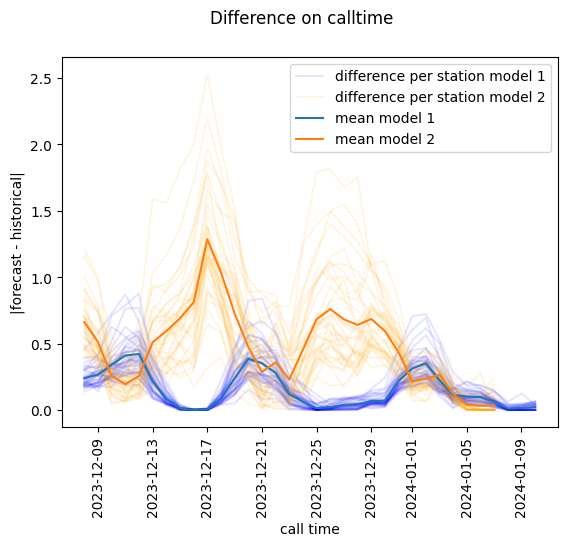

In [20]:
merge1 = dataset_model_1.get_merge()
merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()


fig, ax1 = plt.subplots()
fig.suptitle("Difference on calltime")


individual_groups = merge1.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="blue",
        alpha=0.1,
        label="difference per station model 1" if not idx else "",
    )

individual_groups = merge2.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="orange",
        alpha=0.1,
        label="difference per station model 2" if not idx else "",
    )

# add mean values

call_time_groups_1 = merge1.groupby(["call_time"]).mean()
t = call_time_groups_1.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9)
ax1.plot(t, call_time_groups_1["precipitation_error"], label="mean model 1")

call_time_groups_2 = merge2.groupby(["call_time"]).mean()
t = call_time_groups_2.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9)
ax1.plot(t, call_time_groups_2["precipitation_error"], label="mean model 2")

# add rain


ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel("call time")
ax1.set_ylabel("|forecast - historical|")
ax1.legend()

# compute correlation
print(
    call_time_groups_1["precipitation_error"].values.shape,
    call_time_groups_2["precipitation_error"].values[: len(call_time_groups_1)],
)
x = np.stack(
    [
        call_time_groups_1["precipitation_error"].values[: len(call_time_groups_2) - 1],
        call_time_groups_2["precipitation_error"].values[: len(call_time_groups_1)][
            :-1
        ],
    ]
)
print(x @ x.T)

which time between 0 and 24 is prone to errors


                call_time  station_id                time  \
0     2023-12-11 00:10:01         757 2023-12-13 23:00:00   
1     2023-12-11 00:10:01         757 2023-12-14 02:00:00   
2     2023-12-11 00:10:01         757 2023-12-14 05:00:00   
3     2023-12-11 00:10:01         757 2023-12-14 08:00:00   
4     2023-12-11 00:10:01         757 2023-12-14 11:00:00   
...                   ...         ...                 ...   
56695 2023-12-26 00:10:01        2575 2024-01-04 08:00:00   
56696 2023-12-26 00:10:01        2575 2024-01-04 11:00:00   
56697 2023-12-26 00:10:01        2575 2024-01-04 14:00:00   
56698 2023-12-26 00:10:01        2575 2024-01-04 17:00:00   
56699 2023-12-26 00:10:01        2575 2024-01-04 20:00:00   

       precipitation_forecast  air_temperature_forecast  precipitation_real  \
0                         0.3                       NaN                 5.3   
1                         0.4                       NaN                 1.3   
2                         0.3 

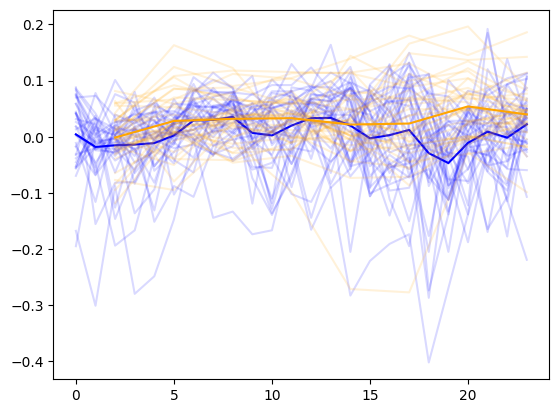

In [21]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()

# insert hour column
merge1.insert(
    len(merge1.columns), "hour", merge1["time"].dt.hour, allow_duplicates=True
)

individual_groups = merge1.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="blue",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

time_group = merge1.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values, c="b")

# insert hour column
merge2.insert(
    len(merge2.columns), "hour", merge2["time"].dt.hour, allow_duplicates=True
)
print(merge2)
individual_groups = merge2.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"] / 3,
        c="orange",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

time_group = merge2.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values / 3, c="orange")

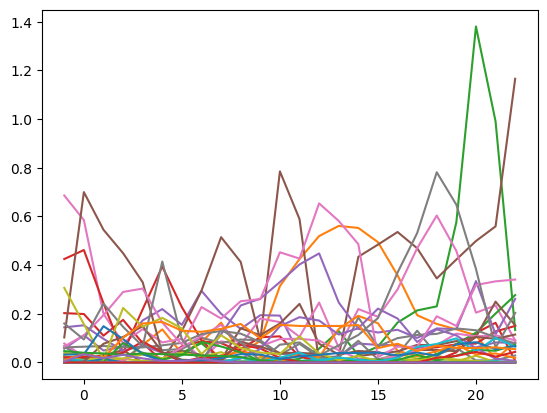

In [22]:
from scipy.stats import linregress

merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# fig, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
fig, ax1 = plt.subplots()


# insert column
merge1.insert(
    len(merge1.columns), "hour", merge1["time"].dt.hour, allow_duplicates=True
)

first_call_time = merge1["call_time"].unique()[0]
# station_data = merge1[(merge1["station_id"] == STATION_ID) & (merge1["call_time"] == first_call_time)].sort_values(by="time")
# station_data = merge1[(merge1["station_id"] == STATION_ID)].groupby("time").mean()
station_data = merge1.groupby("time").mean()
# ax1.plot(station_data["time"], station_data["precipitation_forecast"])

# values = station_data["precipitation_error"].values.reshape(3, len(station_data) // 3).T
# t = station_data["hour"].values.reshape(3, len(station_data) // 3)
t = station_data["hour"].values
t[t == 23] = -1
index = np.where(t == -1)[0]
t = np.split(t, index)
values = station_data["precipitation_error"].values
values = np.split(values, index)

for t, v in zip(t, values):
    ax1.plot(t, np.abs(v))

# ax1.set_yscale("log")
# t
# time_group_slope = merge2.groupby(["station_id", "time"]).apply(lin_reg)
# for idx, station_id in enumerate(time_group_slope.index.get_level_values("station_id").unique()):
#     sub_df = time_group_slope.xs(station_id, level="station_id")
#     slope, intercept, r_2 = zip(*sub_df.values)
#     ax1.plot(sub_df.index, slope, c="blue", alpha=0.15, label="slope" if not idx else "")
#     # ax1.plot(sub_df.index, intercept, c="green", alpha=0.15, label="intercept" if not idx else "")
#     ax1.plot(sub_df.index, r_2, c="orange", alpha=0.15, label="difference per station model 2" if not idx else "")

change of forecast


/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


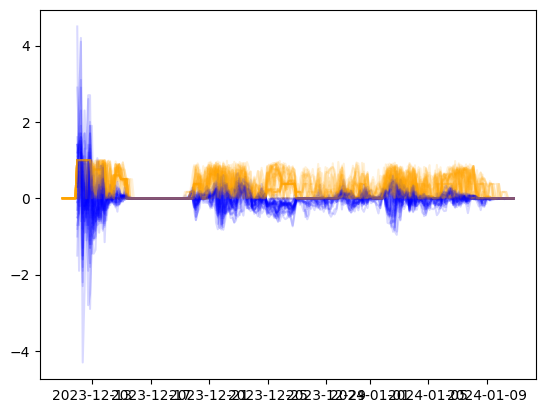

In [23]:
from scipy.stats import linregress

merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()


def lin_reg(series):
    if not len(series):
        return 0, 1

    series = series.sort_values(by="call_time")

    x = np.arange(len(series))
    y = series[
        "precipitation_error"
    ].abs()  # expect: negative slope -> the error should go down if we move closer to the prediction time
    # y = series["precipitation_forecast"]  # look if the forecast is more over or under estimating  with the assumption that the error goes down if we move further to the target
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value**2


time_group_slope = merge2.groupby(["station_id", "time"]).apply(lin_reg)
for idx, station_id in enumerate(
    time_group_slope.index.get_level_values("station_id").unique()
):
    sub_df = time_group_slope.xs(station_id, level="station_id")
    slope, intercept, r_2 = zip(*sub_df.values)
    ax1.plot(
        sub_df.index, slope, c="blue", alpha=0.15, label="slope" if not idx else ""
    )
    # ax1.plot(sub_df.index, intercept, c="green", alpha=0.15, label="intercept" if not idx else "")
    ax1.plot(
        sub_df.index,
        r_2,
        c="orange",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

(257, Timestamp('2023-12-14 23:00:00'))


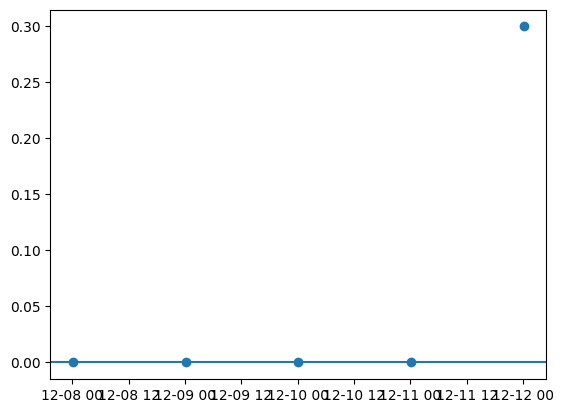

In [24]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax2 = plt.subplots()


for index, values in merge2.groupby(["station_id", "time"]):
    if len(values) < 5:
        continue
    print(index)
    ax2.scatter(values["call_time"], values["precipitation_forecast"])
    ax2.axhline(values["precipitation_real"].values[0])
    break

In [25]:
import pandas as pd

# Create a sample DataFrame
data = {
    "Category": ["A", "A", "B", "B", "A", "B"],
    "Value": [10, 15, 20, 18, 25, 22],
    "Value2": [11, 15, 21, 19, 25, 23],
}
df = pd.DataFrame(data)


# Define a custom aggregate function
def custom_aggregate(series):
    print(series)
    print("_____")
    return series.max() - series.min()


# Apply the custom aggregate function using groupby and aggregate
result = df.groupby("Category").aggregate(custom_aggregate)

print(result)

0    10
1    15
4    25
Name: Value, dtype: int64
_____
2    20
3    18
5    22
Name: Value, dtype: int64
_____
0    11
1    15
4    25
Name: Value2, dtype: int64
_____
2    21
3    19
5    23
Name: Value2, dtype: int64
_____
          Value  Value2
Category               
A            15      14
B             4       4


In [26]:
def get_delta_seconds(series):
    return series.total_seconds()

       precipitation_forecast  air_temperature_forecast  precipitation_real  \
0                         0.5                      11.8                 0.0   
1                         0.3                      12.0                 0.0   
2                         0.3                      12.1                 0.0   
3                         0.3                      12.0                 0.0   
4                         0.2                      11.7                 0.0   
...                       ...                       ...                 ...   
85641                     0.0                       8.0                 0.0   
85642                     0.0                       7.8                 0.0   
85643                     0.0                       7.7                 0.0   
85644                     0.0                       7.8                 0.0   
85645                     0.0                       7.6                 0.0   

       air_temperature_real  precipitation_error  a

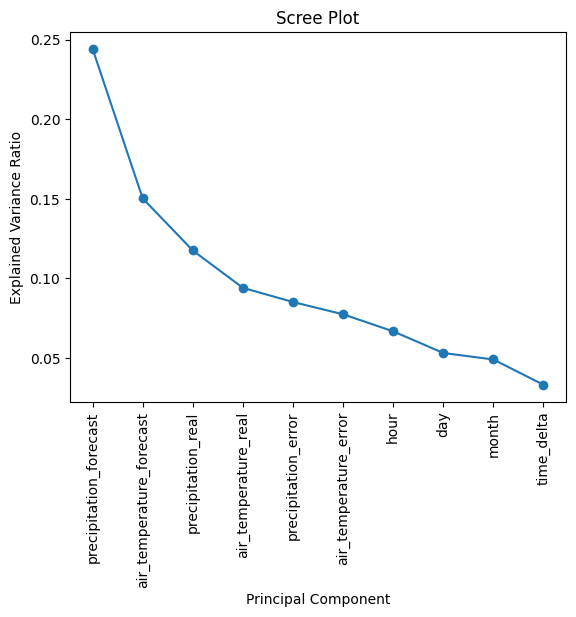

In [27]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()
merge2 = merge2.drop(columns=["air_temperature_forecast", "air_temperature_error"])


station_meta = dataset_model_1._stations
used_station_ids = merge1["station_id"].unique()
station_meta = station_meta[
    station_meta["Stations_ID"].isin(used_station_ids)
    & (station_meta["Kennung"] == "MN")
]
coords = station_meta[["Stations_ID", "Breite", "Länge", "Stations-höhe"]]
coords = coords.rename(
    columns={
        "Stations_ID": "station_id",
        "Breite": "lat",
        "Länge": "lon",
        "Stations-höhe": "height",
    }
)
# merge1 = merge2

# Extract relevant features from datetime
merge1["hour"] = merge1["time"].dt.hour
merge1["day"] = merge1["time"].dt.day
merge1["month"] = merge1["time"].dt.month
time_delta = (merge1["time"] - merge1["call_time"]).apply(get_delta_seconds)
merge1["time_delta"] = time_delta


merge1["call_day"] = merge1["call_time"].dt.day
merge1["call_month"] = merge1["call_time"].dt.day

merge1 = pd.merge(merge1, coords, how="left", on="station_id")

# Drop the original datetime column
merge1 = merge1.drop(columns="time")
merge1 = merge1.drop(columns="call_time")
merge1 = merge1.drop(columns="station_id")

print(merge1)
# merge1 = merge1.drop(columns=["height", "air_temperature_forecast", "air_temperature_real", "air_temperature_error"])
# merge1 = merge1.drop(columns=["precipitation_forecast", "precipitation_real"])


merge1

# drop columns with nan
# TODO: there are nans in the data. WHY
print(merge1.isna().sum(axis=0))
merge1 = merge1.dropna()

# Standardize numeric features
numeric_columns = merge1.columns
scaler = StandardScaler()
merge1[numeric_columns] = scaler.fit_transform(merge1[numeric_columns])

# Perform PCA
n_components = 10
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(merge1[numeric_columns])

# Print the explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)
print("Cummulative explained variance ratio: ", pca.explained_variance_ratio_.sum())

print(pca.feature_names_in_)
component_df = pd.DataFrame(pca.components_, columns=pca.feature_names_in_)
variance_df = pd.DataFrame(
    pca.explained_variance_ratio_[None], columns=pca.feature_names_in_[:n_components]
)

import matplotlib.pyplot as plt

fig, ax2 = plt.subplots()

ax2.plot(variance_df.columns, variance_df.values.T, marker="o")
# ax.plot(range(1, len(pca.explained_variance_ratio_) + 1),
#          pca.explained_variance_ratio_, marker='o')
ax2.set_title("Scree Plot")
ax2.set_xlabel("Principal Component")
ax2.set_ylabel("Explained Variance Ratio")
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)

precipitation_forecast      0
air_temperature_forecast    0
precipitation_real          0
air_temperature_real        0
precipitation_error         0
air_temperature_error       0
hour                        0
day                         0
month                       0
time_delta                  0
call_day                    0
call_month                  0
lat                         0
lon                         0
height                      0
dtype: int64


<Axes: >

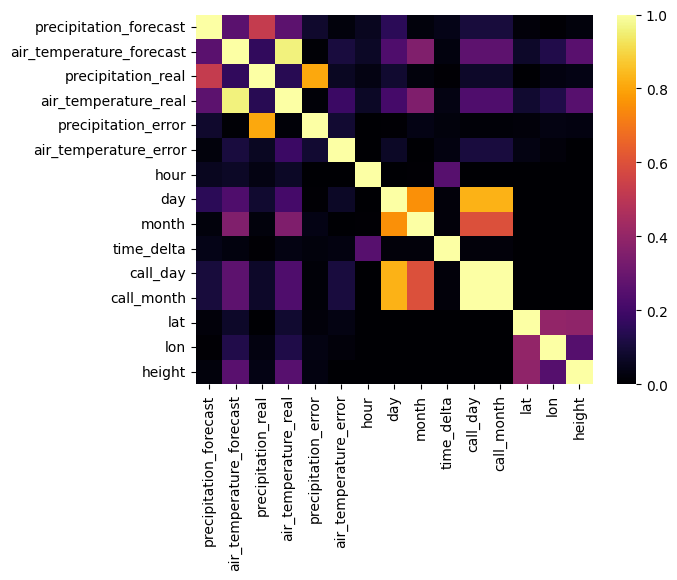

In [28]:
import seaborn as sn

print(merge1.isna().sum(axis=0))

names = merge1.columns
corr = merge1.corr()
sn.heatmap(corr.abs(), cmap="inferno", vmax=1, vmin=0)

Calculate rain detection

Question with with threshold can you be sure rain happens


percentage of rain samples:  0.21543329519183615
percentage of rain samples:  0.2965961199294533


Text(0.5, 0.98, 'confusion statistics of precipitation forecast')

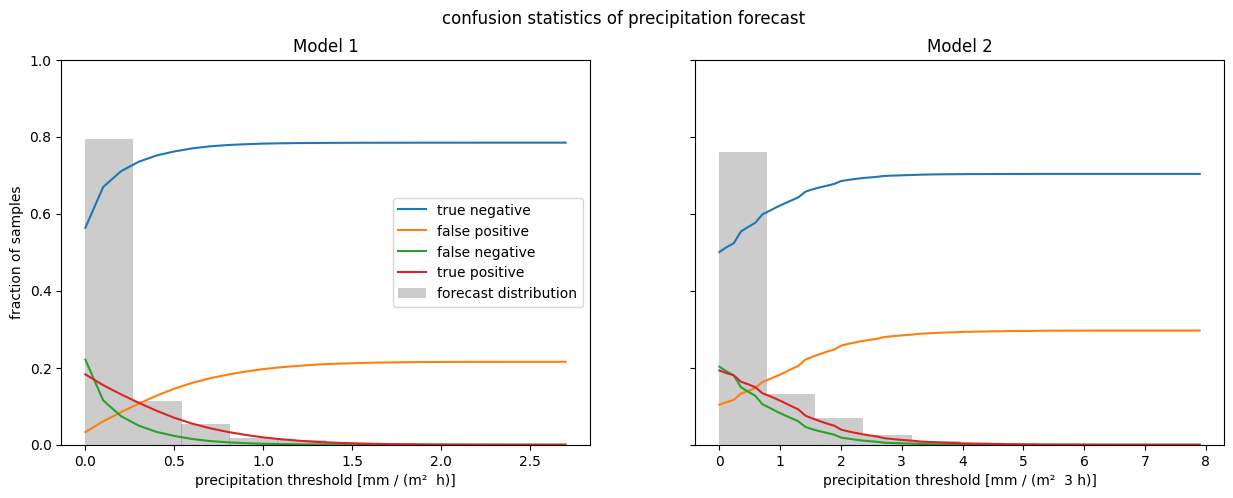

In [29]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

from sklearn import metrics


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        return int(series > threshold)

    return inner


def create_confusion_matrices(df: pd.DataFrame, num_thresholds: int):
    actual = df["precipitation_real"].transform(bool_mask(0.0)).values
    print("percentage of rain samples: ", actual.sum() / len(actual))
    max_forecast = max(df["precipitation_forecast"])
    thresholds = np.linspace(0, max_forecast, num_thresholds)
    matrices = np.empty((num_thresholds, 2, 2))
    for idx, threshold in enumerate(thresholds):
        predicted = (
            df["precipitation_forecast"]
            .transform(bool_mask(threshold=threshold))
            .values
        )
        matrices[idx] = metrics.confusion_matrix(actual, predicted)

    return thresholds, matrices


unique_forecasts_1 = merge1["precipitation_forecast"].unique()
unique_forecasts_2 = merge2["precipitation_forecast"].unique()


thresholds1, matrices1 = create_confusion_matrices(merge1, len(unique_forecasts_1))
thresholds2, matrices2 = create_confusion_matrices(merge2, len(unique_forecasts_2))
counts1 = np.apply_over_axes(np.sum, matrices1, [-2, -1])
counts2 = np.apply_over_axes(np.sum, matrices2, [-2, -1])
matrices1 = np.divide(matrices1, counts1)
matrices2 = np.divide(matrices2, counts2)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)

ax1.plot(thresholds1, matrices1[:, 0, 0], label="true negative")
ax1.plot(thresholds1, matrices1[:, 1, 0], label="false positive")
ax1.plot(thresholds1, matrices1[:, 0, 1], label="false negative")
ax1.plot(thresholds1, matrices1[:, 1, 1], label="true positive")

counts, bins = np.histogram(merge1["precipitation_forecast"])
density = counts / sum(counts)
bin_width = bins[1] - bins[0]
ax1.bar(
    bins[:-1] + bin_width / 2,
    density,
    zorder=0,
    alpha=0.4,
    width=0.271,
    color="grey",
    label="forecast distribution",
)


ax2.plot(thresholds2, matrices2[:, 0, 0], label="true negative")
ax2.plot(thresholds2, matrices2[:, 1, 0], label="false positive")
ax2.plot(thresholds2, matrices2[:, 0, 1], label="false negative")
ax2.plot(thresholds2, matrices2[:, 1, 1], label="true positive")

counts, bins = np.histogram(merge2["precipitation_forecast"])
density = counts / sum(counts)
bin_width = bins[1] - bins[0]
ax2.bar(
    bins[:-1] + bin_width / 2,
    density,
    zorder=0,
    alpha=0.4,
    width=0.79,
    color="grey",
    label="forecast distribution",
)

ax1.legend()
ax1.set_xlabel("precipitation threshold [mm / (m²  h)]")
ax1.set_ylabel("fraction of samples")
ax1.set_ylim((0, 1))
ax1.set_title("Model 1")

ax2.set_title("Model 2")
ax2.set_xlabel("precipitation threshold [mm / (m²  3 h)]")
fig.suptitle("confusion statistics of precipitation forecast")

/tmp/ipykernel_17641/1539526784.py:18: RuntimeWarning: invalid value encountered in divide
  recall1 = true_positive_1 / (true_positive_1 + false_negative_1)
/tmp/ipykernel_17641/1539526784.py:20: RuntimeWarning: invalid value encountered in divide
  sensitivity1 = true_positive_1 / (true_positive_1 + false_negative_1)
/tmp/ipykernel_17641/1539526784.py:25: RuntimeWarning: invalid value encountered in divide
  recall2 = true_positive_2 / (true_positive_2 + false_negative_2)
/tmp/ipykernel_17641/1539526784.py:27: RuntimeWarning: invalid value encountered in divide
  sensitivity2 = true_positive_2 / (true_positive_2 + false_negative_2)


Text(0.5, 0.98, 'confusion statistics of precipitation forecast')

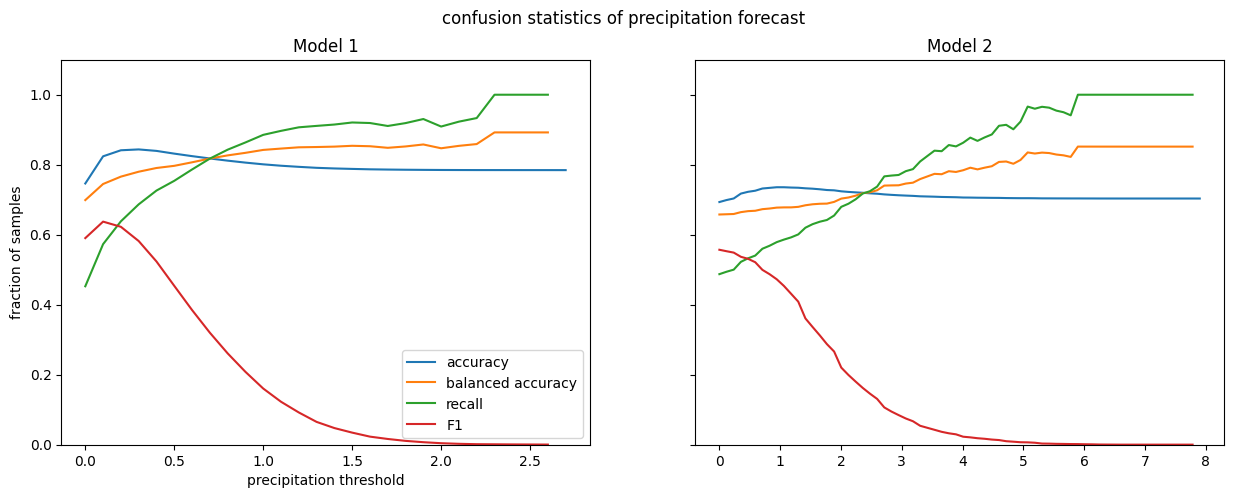

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)

true_negative_1 = matrices1[:, 0, 0]
false_positive_1 = matrices1[:, 1, 0]
false_negative_1 = matrices1[:, 0, 1]
true_positive_1 = matrices1[:, 1, 1]

true_negative_2 = matrices2[:, 0, 0]
false_positive_2 = matrices2[:, 1, 0]
false_negative_2 = matrices2[:, 0, 1]
true_positive_2 = matrices2[:, 1, 1]


accuracy1 = true_positive_1 + true_negative_1
accuracy2 = true_positive_2 + true_negative_2

precision1 = true_positive_1 / (true_positive_1 + false_positive_1)
recall1 = true_positive_1 / (true_positive_1 + false_negative_1)
f1_1 = 2 * precision1 * recall1 / (precision1 + recall1)
sensitivity1 = true_positive_1 / (true_positive_1 + false_negative_1)
specificity1 = true_negative_1 / (true_negative_1 + false_positive_1)
balanced_accuracy1 = (sensitivity1 + specificity1) / 2

precision2 = true_positive_2 / (true_positive_2 + false_positive_2)
recall2 = true_positive_2 / (true_positive_2 + false_negative_2)
f1_2 = 2 * precision2 * recall2 / (precision2 + recall2)
sensitivity2 = true_positive_2 / (true_positive_2 + false_negative_2)
specificity2 = true_negative_2 / (true_negative_2 + false_positive_2)
balanced_accuracy2 = (sensitivity2 + specificity2) / 2


ax1.plot(thresholds1, accuracy1, label="accuracy")
ax2.plot(thresholds2, accuracy2, label="accuracy")
ax1.plot(thresholds1, balanced_accuracy1, label="balanced accuracy")
ax2.plot(thresholds2, balanced_accuracy2, label="balanced accuracy")

# ax1.plot(thresholds1, precision1, label="precision")
# ax2.plot(thresholds2, precision2, label="precision")
ax1.plot(thresholds1, recall1, label="recall")
ax2.plot(thresholds2, recall2, label="recall")

ax1.plot(thresholds1, f1_1, label="F1")
ax2.plot(thresholds2, f1_2, label="F1")


ax1.legend()
ax1.set_xlabel("precipitation threshold")
ax1.set_ylabel("fraction of samples")
ax1.set_ylim((0, 1.1))
ax1.set_title("Model 1")
ax2.set_title("Model 2")
fig.suptitle("confusion statistics of precipitation forecast")

samples per time step into the future:  [22.56111111 22.6879085  22.05637255 22.11437908 22.19199346 22.44117647
 22.18218954 22.43872549 22.45343137 22.33823529 22.48366013 22.78676471
 22.6372549  22.7753268  22.57761438 22.36601307 22.12009804 21.77042484
 22.02777778 22.20669935 22.30228758 22.23284314 22.33905229 22.26552288
 22.16421569 22.44781145 21.86868687 21.94276094 21.996633   22.27609428
 22.10690236 22.59006734 22.78451178 22.66329966 22.81818182 23.07828283
 22.8956229  23.00757576 22.69444444 22.44360269 22.07744108 21.67424242
 22.04545455 22.23989899 22.27525253 22.17424242 22.29377104 22.43686869
 22.34511785 22.35763889 21.74739583 21.76041667 21.75434028 22.05989583
 21.88020833 22.37239583 22.47048611 22.36892361 22.52951389 22.77690972
 22.60503472 22.80295139 22.52604167 22.45399306 22.40538194 22.125
 22.51909722 22.6171875  22.58680556 22.5625     22.79947917 22.81597222]


Text(0.5, 1.0, 'With which threshold can I get the best accuracy')

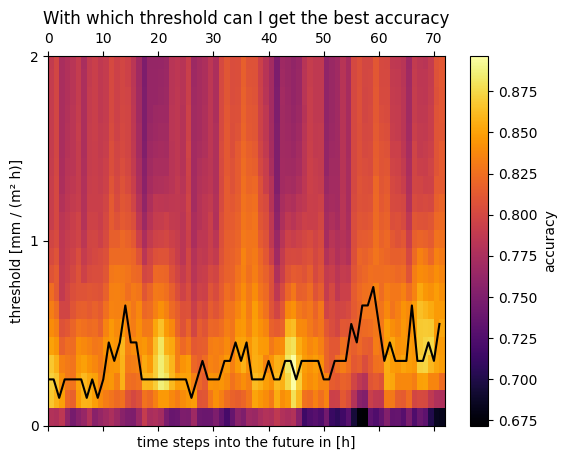

In [31]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# add time delta
# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        result = series > threshold
        return result

    return inner


# print(merge1.groupby("time_delta")[["precipitation_real", "precipitation_forecast", "precipitation_error"]].aggregate(bool_mask(0.0)))

# set bool mask for actual values
num_thresholds = len(merge1["precipitation_forecast"].unique())
num_time_deltas = len(merge1["time_delta"].unique())
max_forecast = max(merge1["precipitation_forecast"])
thresholds = np.linspace(0, max_forecast, num_thresholds)
matrices = np.empty((num_time_deltas - 1, num_thresholds, 2, 2))
for group_index, (_, group) in enumerate(
    merge1.groupby("time_delta")[
        ["precipitation_real", "precipitation_forecast", "precipitation_error"]
    ]
):
    actual = group["precipitation_real"].apply(bool_mask(0.0)).values
    if len(group) == 2:
        continue
    for threshold_idx, threshold in enumerate(thresholds):
        transformed = group.apply(bool_mask(threshold=threshold))
        predicted = transformed["precipitation_forecast"].values
        matrices[group_index, threshold_idx] = metrics.confusion_matrix(
            actual, predicted
        )

samples_per_bucket = np.apply_over_axes(np.sum, matrices, [-2, -1])
matrices = np.divide(matrices, samples_per_bucket)

true_negative_1 = matrices[..., 0, 0]
false_positive_1 = matrices[..., 1, 0]
false_negative_1 = matrices[..., 0, 1]
true_positive_1 = matrices[..., 1, 1]


accuracy = (true_positive_1 + true_negative_1).T

print("samples per time step into the future: ")

# accuracy /= accuracy.sum(axis=0)

fig, ax1 = plt.subplots()

extent = [0, 72, max_forecast, 0]
cbar = ax1.matshow(accuracy, extent=extent, cmap="inferno")
ax1.set_aspect("auto")

threshold_bucket_with = thresholds[1]
argmax_threshold = thresholds[accuracy.argmax(axis=0)] + threshold_bucket_with / 2
ax1.plot(argmax_threshold, c="k", label="argmax_threshold")

std_over_time = accuracy.std(axis=0)
ax1.set_ylim((0, 2))
ax1.set_ylabel("threshold [mm / (m² h)]")
ax1.set_xlabel("time steps into the future in [h]")


cbar = fig.colorbar(cbar)
cbar.set_label("accuracy")

std_over_time / max_forecast

ax1.set_title("With which threshold can I get the best accuracy")

samples per time step into the future:  [[[[1152.]]

  [[1152.]]

  [[1152.]]

  ...

  [[1152.]]

  [[1152.]]

  [[1152.]]]


 [[[1116.]]

  [[1116.]]

  [[1116.]]

  ...

  [[1116.]]

  [[1116.]]

  [[1116.]]]


 [[[1116.]]

  [[1116.]]

  [[1116.]]

  ...

  [[1116.]]

  [[1116.]]

  [[1116.]]]


 ...


 [[[ 900.]]

  [[ 900.]]

  [[ 900.]]

  ...

  [[ 900.]]

  [[ 900.]]

  [[ 900.]]]


 [[[ 900.]]

  [[ 900.]]

  [[ 900.]]

  ...

  [[ 900.]]

  [[ 900.]]

  [[ 900.]]]


 [[[ 900.]]

  [[ 900.]]

  [[ 900.]]

  ...

  [[ 900.]]

  [[ 900.]]

  [[ 900.]]]]
[1.35597015 0.88432836 0.64850746 0.41268657 0.41268657 0.76641791
 1.2380597  1.12014925 1.2380597  1.00223881 0.88432836 0.88432836
 0.53059701 1.00223881 1.35597015 1.35597015 1.35597015 0.64850746
 0.76641791 0.88432836 1.2380597  0.64850746 1.00223881 0.76641791
 1.2380597  0.64850746 0.76641791 4.53955224 0.29477612 0.29477612
 3.36044776 3.83208955 3.83208955 0.76641791 1.2380597  1.35597015
 1.2380597  0.64850746 1.59179

Text(0.5, 1.0, 'With which threshold can I get the best accuracy')

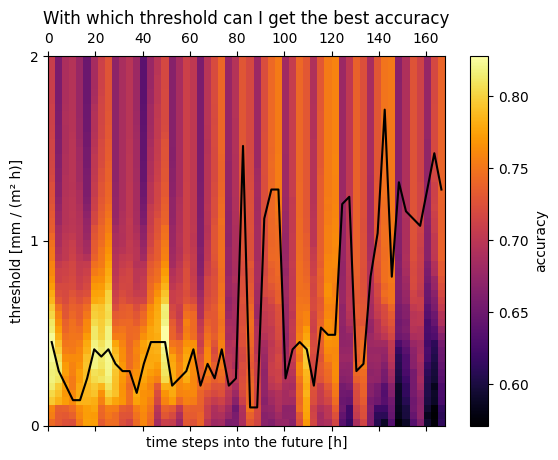

In [35]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# add time delta
# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        result = series > threshold
        return result

    return inner


# print(merge1.groupby("time_delta")[["precipitation_real", "precipitation_forecast", "precipitation_error"]].aggregate(bool_mask(0.0)))

# set bool mask for actual values
num_thresholds = len(merge2["precipitation_forecast"].unique())
num_time_deltas = len(merge2["time_delta"].unique())
max_forecast = max(merge2["precipitation_forecast"])
thresholds = np.linspace(0, max_forecast, num_thresholds)
matrices = np.empty((num_time_deltas, num_thresholds, 2, 2))
time_deltas = []
for group_index, (time_delta, group) in enumerate(
    merge2.groupby("time_delta")[
        ["precipitation_real", "precipitation_forecast", "precipitation_error"]
    ]
):
    actual = group["precipitation_real"].apply(bool_mask(0.0)).values
    time_deltas.append(time_delta.seconds)
    if len(group) == 2:
        continue
    for threshold_idx, threshold in enumerate(thresholds):
        transformed = group.apply(bool_mask(threshold=threshold))
        predicted = transformed["precipitation_forecast"].values
        matrices[group_index, threshold_idx] = metrics.confusion_matrix(
            actual, predicted
        )
time_deltas = np.array(sorted(time_deltas)) // 3600

samples_per_bucket = np.apply_over_axes(np.sum, matrices, [-2, -1])
print("samples per time step into the future: ", samples_per_bucket)

matrices = np.divide(matrices, samples_per_bucket)

true_negative_1 = matrices[..., 0, 0]
false_positive_1 = matrices[..., 1, 0]
false_negative_1 = matrices[..., 0, 1]
true_positive_1 = matrices[..., 1, 1]


accuracy = (true_positive_1 + true_negative_1).T


# accuracy /= accuracy.sum(axis=0)

fig, ax2 = plt.subplots()


extent = [0, 56 * 3, max_forecast / 3 , 0]
cbar = ax2.matshow(accuracy, extent=extent, cmap="inferno")
ax2.set_aspect("auto")

threshold_bucket_with = thresholds[1]
argmax_threshold = thresholds[accuracy.argmax(axis=0)] + threshold_bucket_with / 2
print(argmax_threshold)
ax2.plot(np.arange(56) * 3 + 1.5, argmax_threshold / 3, c="k", label="argmax_threshold")

ax2.set_ylim((0, 2))
ax2.set_ylabel("threshold [mm / (m² h)]")
ax2.set_xlabel("time steps into the future [h]")


cbar = fig.colorbar(cbar)
cbar.set_label("accuracy")


ax2.set_title("With which threshold can I get the best accuracy")

Whats the probability given a certain forecast to really getting wet

In [33]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

actual = merge1["precipitation_real"].apply(bool_mask(0))

threshold = 0.2
predition = merge1["precipitation_forecast"]

relative error to amount of rain $ (forecast - historical) / historical$


Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error


In [34]:
merge1 = dataset_model_1.get_merge

Compute on average divergence for a forecast into the future.
Observer how a forecast changes over time

relative error to amount of rain $ (forecast - historical) / historical$


jooy plot for precipitation amount across stations

----> time
|
|
V
station

z: precipitation amount of precipitation
